<h1><center>Classification of a Quench Detection Signal</center></h1>

# 0. Initialise the working environment
## 0.1 Install required packages for SWAN

In [1]:
import sys
if sys.version_info < (3,0):
    raise Warning("Not available for Python2. Compatible with Python3 only!")

## 0.2. Import useful packages

In [2]:
# External libraries
from numpy import linalg as LA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from IPython.display import display, HTML
import math

# Internal libraries
from lhcsmapi.metadata.SignalMetadata import SignalMetadata
from lhcsmapi.dbsignal.post_mortem.PmDbRequest import PmDbRequest
from lhcsmapi.dbsignal.Signal import Signal
from lhcsmapi.dbsignal.SignalUtilities import SignalUtilities
from lhcsmapi.Time import Time

# 1. Algorithm
1. For a given timestamp and circuit type find quench detection signals
 - Convert the list of sources and timestamps into a tabular dataframe
 - Remove duplicate quench detection sources (Board A/B duplicates)
 - Sort table according to the timestamp in the ascending order
 - Add the value of current corresponding to the moment of a quench detection
2. Query the first detection signal to be treated as a reference
 - If needed, flip the signal in order to analyze positive increase of the voltage
3. Extract the part of the reference signal with growth until measurement channel's saturation
 - Firstly, extract the signal up to the first maximum
 - Secondly, extract the signal up to the last value below the median value (to cut out the initial noise prior to a quench)
 - Thirdly, shift index to 0
 - Fourthly, shift values to 0
4. For each pair of quench detection source&timestamp in the list of quenched magnets:
 - Query a quench detection signal
    - If needed, flip the signal in order to analyze positive increase of the voltage
 - Roll the reference over the actual signal (shifting the reference to the starting value of the actual signal slice) and calculate Euclidean distance (the lower the value, the more similar two signals are)
 - Rate the quench:
    - If the similarity is below a certain threshold and a quench is less than two seconds from the root quench, rate the signal as a training quench
    - Otherwise, it was not a training quench
 - Plot signals
    - Plot raw reference and actual U_QS0 signals
    - Plot shifted reference signal over the actual one
      - Shift the reference by the index of minimum difference between the reference and actual signals
     
**Note that the analysis for the first PM source&timestamp pair in the loop is a test case for the analysis. The signal is compared to itself, thus the difference should be equal to 0.**

In [3]:
def find_unique_qds_pm(metadata_qds, metadata_fgc, timestamp):
    # For a given timestamp and circuit type find quench detection signals
    source_timestamp_qds = PmDbRequest.find_events(source='*', system=metadata_qds['system'], className=metadata_qds['className'], 
                                                  t_start=timestamp, duration=[(60, 's'), (60, 's')])
    # Convert the list into a pandas dataframe
    source_timestamp_qds_df = pd.DataFrame(source_timestamp_qds)
    source_timestamp_qds_df.columns = ['source_qds', 'timestamp_qds']
    # Remove duplicate magnets
    source_timestamp_qds_df.drop_duplicates(['source_qds'], inplace=True)
    # Sort according to the timestamp
    source_timestamp_qds_df.sort_values(by=['timestamp_qds'], inplace=True)
    source_timestamp_qds_df['timestamp_qds_str'] = source_timestamp_qds_df.apply(lambda row: Time.to_string(row['timestamp_qds']), axis=1)
    # Add quench current
    source_timestamp_fgc = PmDbRequest.find_events(metadata_fgc['source'], metadata_fgc['system'], metadata_fgc['className'], 
                                               t_start=timestamp, duration=[(10, 's'), (400, 's')])
    if len(source_timestamp_fgc) >= 0:
        source_fgc, timestamp_fgc = source_timestamp_fgc[0]
        i_meas_df = Signal().read('pm', system=metadata_fgc['system'], className=metadata_fgc['className'], source=source_fgc,
                               signal='I_MEAS', eventTime=timestamp_fgc)
        if len(i_meas_df) > 0:
            source_timestamp_qds_df['i_quench'] = source_timestamp_qds_df.apply(lambda row: int(i_meas_df.loc[i_meas_df.index[i_meas_df.index.get_loc(row['timestamp_qds'], method='nearest')], 'I_MEAS']), axis=1)
        else:
            source_timestamp_qds_df['i_quench'] = math.nan
    else:
        source_timestamp_qds_df['i_quench'] = math.nan
    return source_timestamp_qds_df

def get_pm_signal(metadata_qds, source_qds, timestamp_qds, U_QS0):
    print('Querying {} on {}.'.format(Time.to_string(timestamp_qds), U_QS0))

    u_qs0_df = Signal().read('pm', append=True, system=metadata_qds['system'], className=metadata_qds['className'], source=source_qds,
                               signal=U_QS0, eventTime=timestamp_qds)
    
    SignalUtilities.synchronize_df(u_qs0_df, timestamp_qds)
    SignalUtilities.convert_indices_to_sec(u_qs0_df)
    
    return u_qs0_df.rolling(window=3, min_periods=1).median()

def flip_u_qs0_signal(u_qs0_ref):
    # # if there is only a negative peak, then flip the signal
    # # if there are two peaks and the first is negative, then flip the signal
    # # otherwise, do nothing
    # # added the case when U_QS0 is saturated only to negative!
    if ((u_qs0_ref.max() < 0.2) and (u_qs0_ref.min() < -0.2)):
        return -deepcopy(u_qs0_ref)
    elif ((u_qs0_ref.max() > 0.2) and (u_qs0_ref.min() < -0.2) and (u_qs0_ref.idxmin() < u_qs0_ref.idxmax())):
        return -deepcopy(u_qs0_ref)
    else:
        return deepcopy(u_qs0_ref)
    
def extract_short_ref(u_qs0_ref):
    # # firstly, we extract the signal up to the first maximum
    u_qs0_ref_short = u_qs0_ref[(u_qs0_ref.index <= u_qs0_ref.idxmax())]
    # # secondly, we extract the signal up to the last datapoint below the 0.0025 (to cut out the initial noise prior to a quench)
    mask_median = u_qs0_ref_short.values < 0.0025
    found_index = np.where(mask_median == True)[0][-1]
    u_qs0_ref_short = u_qs0_ref_short[(u_qs0_ref_short.index > u_qs0_ref_short.index[found_index])]
    # set index to 0
    u_qs0_ref_short.index -= u_qs0_ref_short.index[0]
    # set starting value to 0
    u_qs0_ref_short = u_qs0_ref_short.subtract(u_qs0_ref_short.values[0])
    return u_qs0_ref_short

def distance(x, u_qs0_ref_short_values):
    u_qs0_ref_short_values_shifted = deepcopy(u_qs0_ref_short_values)
    # shift to the starting point of the window
    u_qs0_ref_short_values_shifted += x[0]
    # if value is above 0.25, keep it to 0.25
    if x[0] < 0.15:
        u_qs0_ref_short_values_shifted_sat = [min(0.25, u_qs0_el) for u_qs0_el in u_qs0_ref_short_values_shifted]
    else:
        u_qs0_ref_short_values_shifted_sat = u_qs0_ref_short_values_shifted
    
    return LA.norm(x-u_qs0_ref_short_values_shifted_sat)

def measure_distance_from_ref(u_qs0_act, u_qs0_ref_short):
    corrcoeff_pos = u_qs0_act.rolling(len(u_qs0_ref_short)).apply(distance, args=(u_qs0_ref_short.values,), raw=True).shift(-len(u_qs0_ref_short)+1)
    return abs(corrcoeff_pos).min(), abs(corrcoeff_pos).idxmin()
    
def plot_raw_signals(u_qs0_act, u_qs0_ref, st_magnet_ok_df, source_qds, timestamp_qds, t_after_initial_quench, i_quench):
    # # # plot reference and actual signals
    title = f'Input: {source_qds}, {Time.to_string(timestamp_qds)[:23]}, {t_after_initial_quench:.3f} s after the first quench, current: {i_quench} A'
    ax1 = u_qs0_act.plot(title=title, grid=True, xlim=(-1, 1), legend=True, figsize=(15, 7))
    u_qs0_ref.plot(ax=ax1, grid=True, xlim=(-1, 1), legend=True)
    ax1.set_xlabel("time, [s]", fontsize=15)
    ax1.set_ylabel("U_QS0 [V]", fontsize=15)
    ax1.title.set_size(20)
    ax1.legend(loc='lower left')
    ax1.tick_params(labelsize=15)
    
    ax2 = ax1.twinx()
    st_magnet_ok_df.plot(ax=ax2, style='ro:', xlim=(-1, 1), drawstyle="steps-post")
    ax2.set_ylabel("ST_MAGNET_OK [-]", fontsize=15)
    ax2.legend(loc='upper right')
    ax2.tick_params(labelsize=15)
    
    plt.show()
    
def plot_analysis_results(u_qs0_act_flip, u_qs0_act_flip_short, u_qs0_ref_flip_short, st_magnet_ok_df, source_qds, timestamp_qds, idx_dist_min, t_after_initial_quench, i_quench):
    # plot shifted signal
    title = f'Output: {source_qds}, {Time.to_string(timestamp_qds)[:23]}, {t_after_initial_quench:.3f} s after the first quench, current: {i_quench} A'
    ax1 = u_qs0_act_flip_short.plot(title=title, grid=True, xlim=(-1, 1), legend=True, figsize=(15, 7), color='C0')
    u_qs0_act_flip.plot(ax=ax1, style='--', color='C0')
    # shift the reference by the index of minimum difference between the reference and actual signals
    u_qs0_ref_flip_short_copy = deepcopy(u_qs0_ref_flip_short)
    u_qs0_ref_flip_short_copy.index += idx_dist_min
    # shift value by the value with the minimimum distance
    u_qs0_ref_flip_short_copy = u_qs0_ref_flip_short_copy.add(u_qs0_act_flip.loc[idx_dist_min])
    # saturate value to 0.25 if above
    u_qs0_ref_flip_short_copy.clip(upper=0.25, inplace=True)
    
    # plot short reference signal
    u_qs0_ref_flip_short_copy.plot(ax=ax1, grid=True, xlim=(idx_dist_min-0.25, idx_dist_min+0.25), legend=True, color='C1')
    ax1.set_xlabel("time, [s]", fontsize=15)
    ax1.set_ylabel("U_QS0 [V]", fontsize=15)
    ax1.legend(loc='lower left')
    ax1.title.set_size(20)
    ax1.tick_params(labelsize=15)
    
    ax2 = ax1.twinx()
    st_magnet_ok_df.plot(ax=ax2, style='ro:', xlim=(idx_dist_min-0.25, idx_dist_min+0.25), drawstyle="steps-post")
    ax2.set_ylabel("ST_MAGNET_OK [-]", fontsize=15)
    ax2.legend(loc='upper right')
    ax2.tick_params(labelsize=15)

    plt.show()

# Find FPAs with the RB Quench Analysis GUI
def classify_quench_detection(metadata_qds, metadata_fgc, timestamp, U_QS0_wildcard):
    # For a given timestamp and circuit type find quench detection signals
    source_timestamp_qds_df = find_unique_qds_pm(metadata_qds, metadata_fgc, timestamp)
    display(HTML(source_timestamp_qds_df.to_html()))
    
    # Query the reference detection signal
    source_qds = source_timestamp_qds_df['source_qds'].values[0]
    timestamp_qds = source_timestamp_qds_df['timestamp_qds'].values[0]
    U_QS0 = U_QS0_wildcard.replace('%CELL%', source_qds) # is replace an in-place operation
    u_qs0_ref = get_pm_signal(metadata_qds, source_qds, timestamp_qds, U_QS0)[U_QS0]
    u_qs0_ref_flip = flip_u_qs0_signal(u_qs0_ref)
    # extract a short reference profile:
    u_qs0_ref_flip_short = extract_short_ref(u_qs0_ref_flip)
    
    for index, row in source_timestamp_qds_df.iterrows():
        # # Query signal
        source_qds, timestamp_qds, i_quench = row['source_qds'], row['timestamp_qds'], row['i_quench']
        U_QS0 = U_QS0_wildcard.replace('%CELL%', source_qds) # is replace an in-place operation
        u_qs0_act = get_pm_signal(metadata_qds, source_qds, timestamp_qds, U_QS0)[U_QS0]
        
        # # Query ST_MAGNET_OK
        st_magnet_ok_df = get_pm_signal(metadata_qds, source_qds, timestamp_qds, 'ST_MAGNET_OK')['ST_MAGNET_OK']

        # Flip the actual signal
        u_qs0_act_flip = flip_u_qs0_signal(u_qs0_act)
        
        t_quench_heater = min(u_qs0_act_flip[u_qs0_act_flip.index>-1].idxmax(), st_magnet_ok_df[st_magnet_ok_df.index>-1].idxmin()+0.02)
    
        # # Roll the reference over the actual signal and calculate Euclidean distance (the lower the value, the more similar two signals are)
        dist_min, idx_dist_min = measure_distance_from_ref(u_qs0_act_flip[u_qs0_act_flip.index <= t_quench_heater], u_qs0_ref_flip_short)
        
        print(f"Minimum Euclidean distance to the reference is: {dist_min} at: {idx_dist_min} s")
        # Rate the quench:
        # # if the similarity is below a certain threshold and a quench is less than two seconds from the root quench, rate the signal as a training quench
        # # otherwise, it was not a training quench
        t_after_initial_quench = (timestamp_qds-source_timestamp_qds_df.loc[0, 'timestamp_qds'])*1e-9
        quench_type = 'TRAINING' if (dist_min < 0.1) and (t_after_initial_quench < 2) else 'OTHER'
        print(f'The quench of {source_qds} is classified as {quench_type}.')
        # Plot signals
        plot_raw_signals(u_qs0_act, u_qs0_ref, st_magnet_ok_df, source_qds, timestamp_qds, t_after_initial_quench, i_quench)
        plot_analysis_results(u_qs0_act_flip, u_qs0_act_flip[u_qs0_act_flip.index <= t_quench_heater], u_qs0_ref_flip_short, st_magnet_ok_df, source_qds, timestamp_qds, idx_dist_min, t_after_initial_quench, i_quench)
        

# 2. Get Metadata

In [4]:
circuit_type = 'RB'
circuit_name = 'RB.A12'
metadata_qds = SignalMetadata.get_circuit_signal_database_metadata(circuit_type, circuit_name, 'QDS', 'PM')
metadata_fgc = SignalMetadata.get_circuit_signal_database_metadata(circuit_type, circuit_name, 'PC', 'PM')
U_QS0_wildcard = SignalMetadata.get_signal_name(circuit_type, circuit_name, 'QDS', 'PM', 'U_QS0')

# 2.1. 2018-12-06 19:02:00, B10L2, A10L2

Querying 2018-12-06 19:02:39.366000+01:00 on B10L2:U_QS0.
Querying 2018-12-06 19:02:39.366000+01:00 on B10L2:U_QS0.
Querying 2018-12-06 19:02:39.366000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.0 at: -0.038 s
The quench of B10L2 is classified as TRAINING.


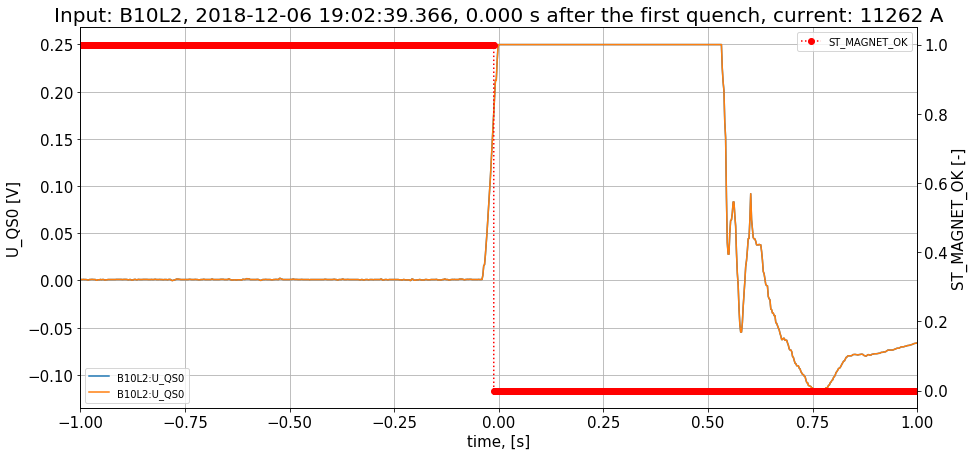

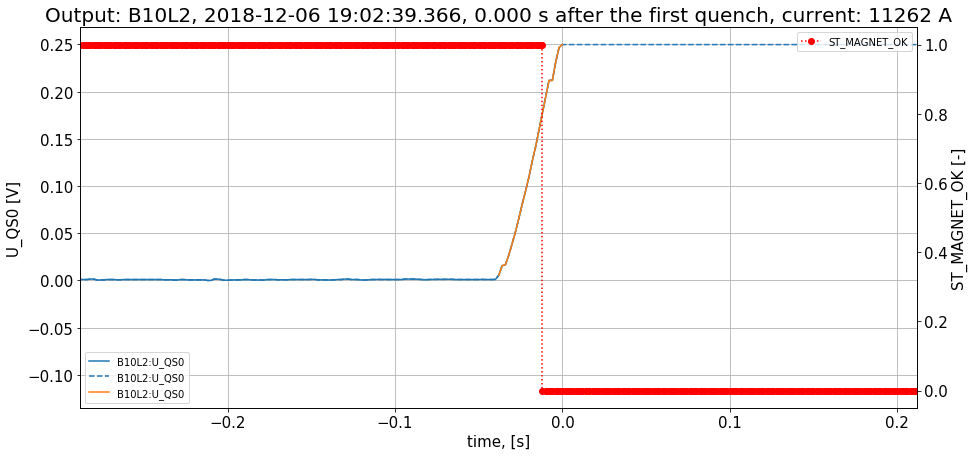

Querying 2018-12-06 19:02:39.603000+01:00 on A10L2:U_QS0.
Querying 2018-12-06 19:02:39.603000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.5658985807392674 at: -0.033 s
The quench of A10L2 is classified as OTHER.


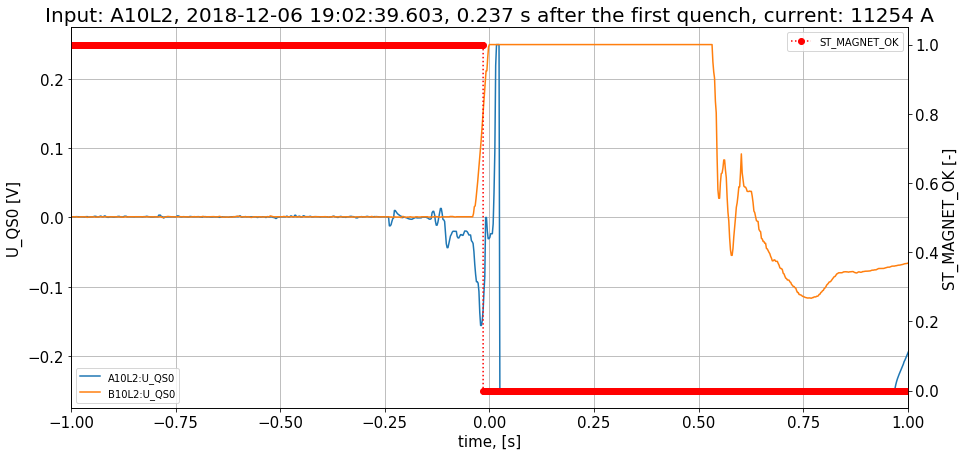

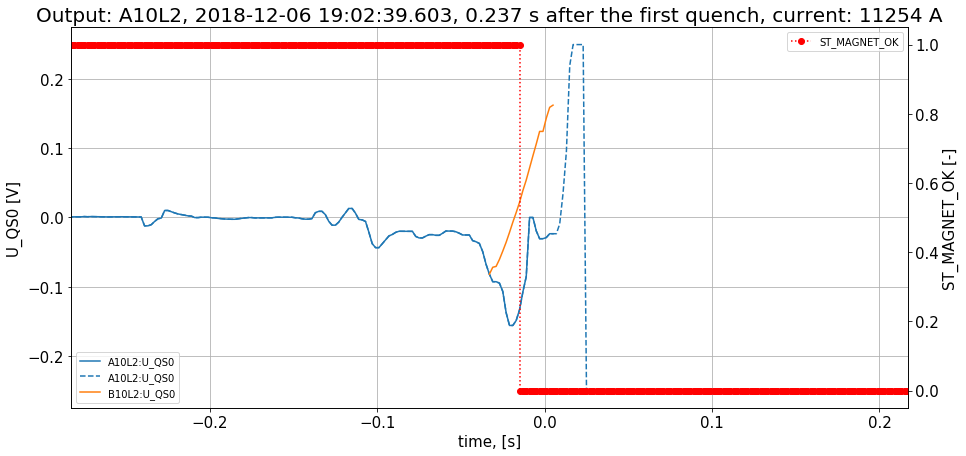

In [5]:
timestamp = '2018-12-06 19:02:00.00'
classify_quench_detection(metadata_qds, metadata_fgc, timestamp, U_QS0_wildcard)

# 2.2. 2018-12-10 06:31:00.00, A20R1, B20R1, C20R1

Querying 2018-12-10 06:31:22.407000+01:00 on A20R1:U_QS0.
Querying 2018-12-10 06:31:22.407000+01:00 on A20R1:U_QS0.
Querying 2018-12-10 06:31:22.407000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 3.469446951953614e-18 at: -0.035 s
The quench of A20R1 is classified as TRAINING.


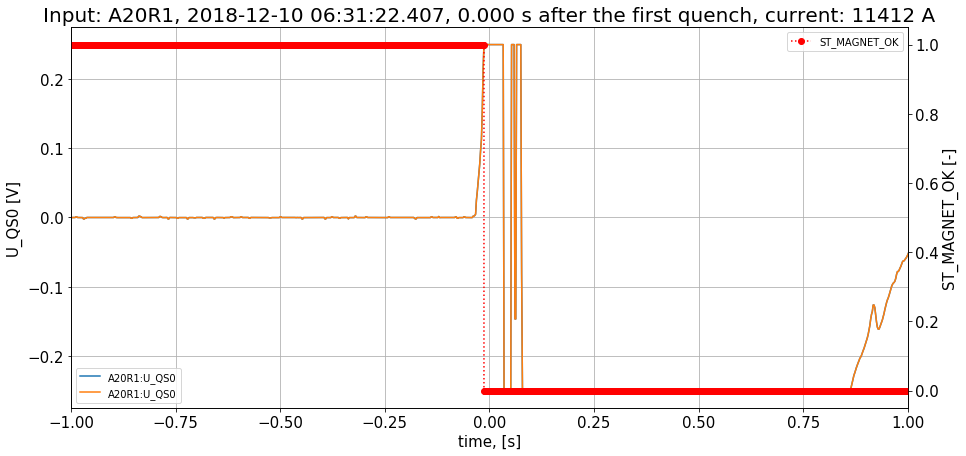

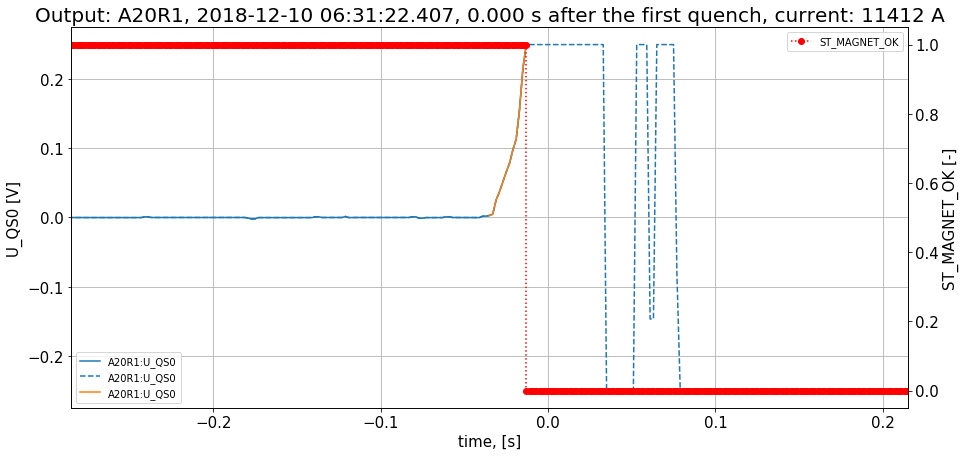

Querying 2018-12-10 06:31:22.823000+01:00 on B20R1:U_QS0.
Querying 2018-12-10 06:31:22.823000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.02547434220120412 at: -0.037 s
The quench of B20R1 is classified as TRAINING.


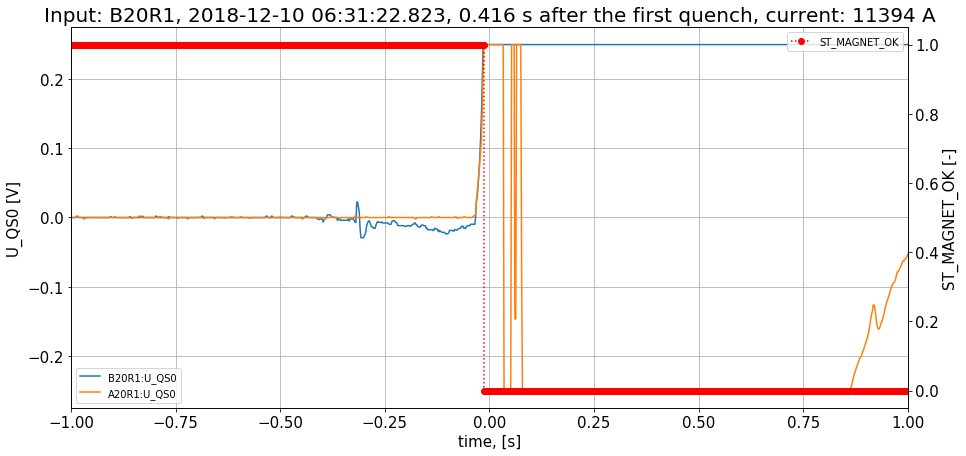

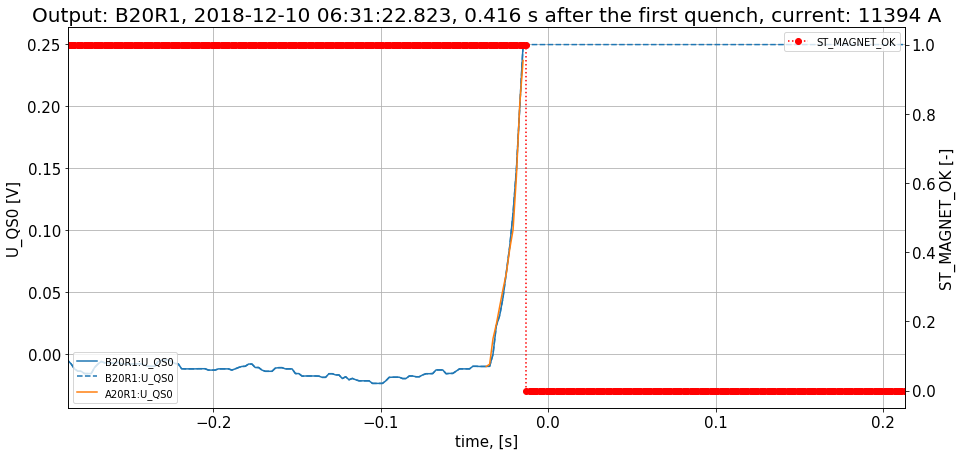

Querying 2018-12-10 06:31:40.164000+01:00 on C20R1:U_QS0.
Querying 2018-12-10 06:31:40.164000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.04098554005157192 at: -0.964 s
The quench of C20R1 is classified as OTHER.


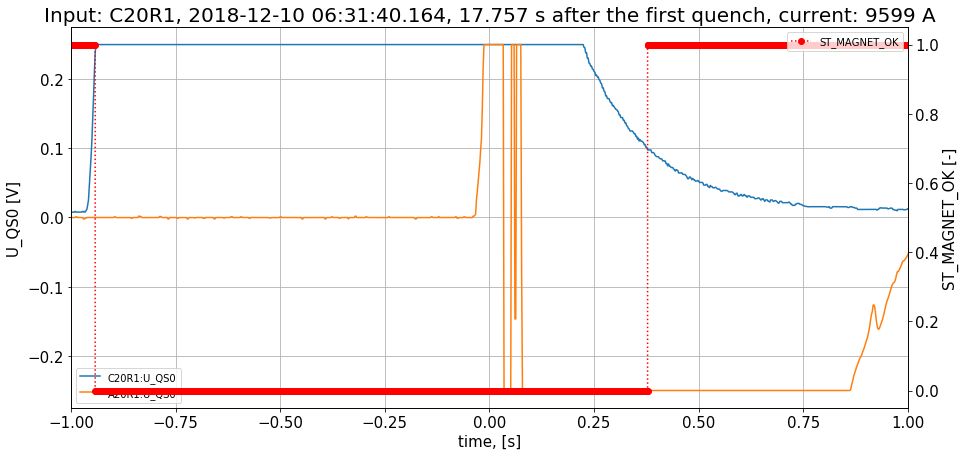

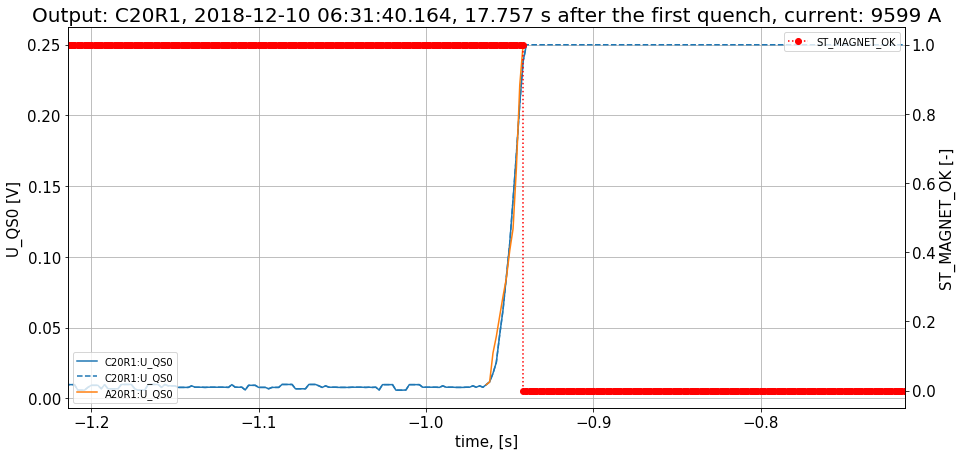

In [6]:
timestamp = '2018-12-10 06:31:00.00'
classify_quench_detection(metadata_qds, metadata_fgc, timestamp, U_QS0_wildcard)

# 2.3. 2018-12-09 16:53:00, B22R1, C22R1, A22R1

Querying 2018-12-09 16:53:09.141000+01:00 on B22R1:U_QS0.
Querying 2018-12-09 16:53:09.141000+01:00 on B22R1:U_QS0.
Querying 2018-12-09 16:53:09.141000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 3.469446951953614e-18 at: -0.925 s
The quench of B22R1 is classified as TRAINING.


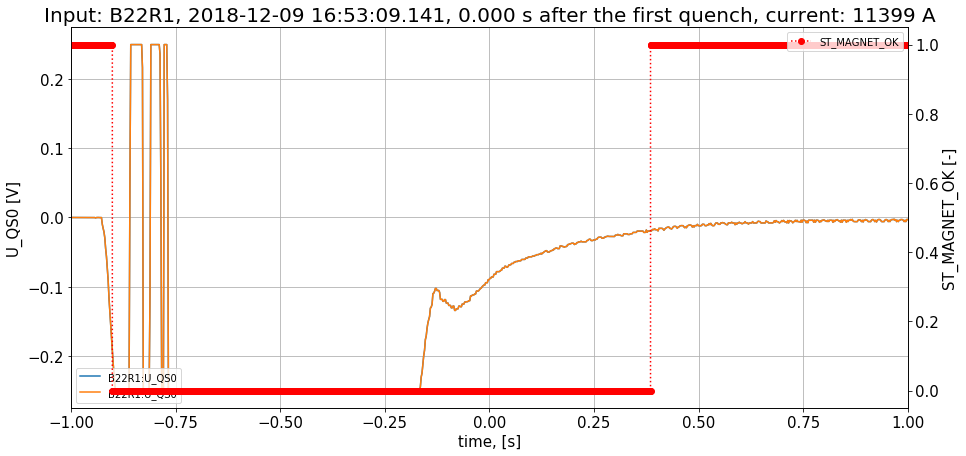

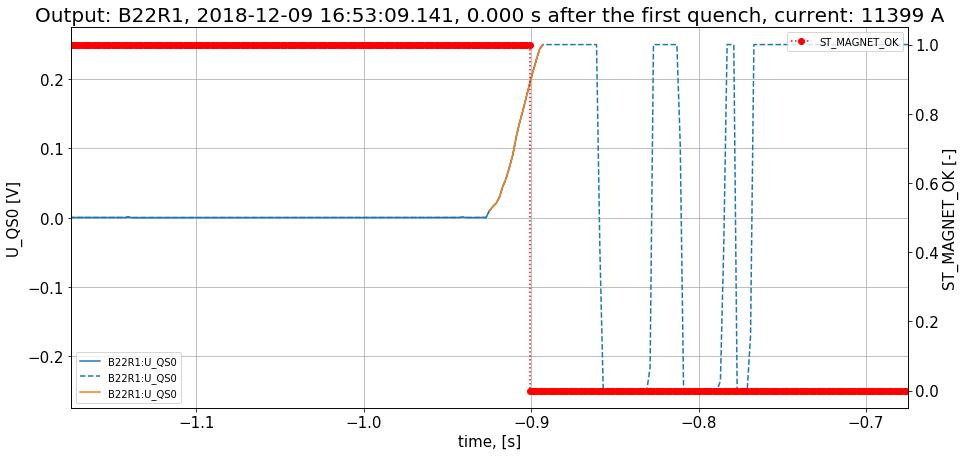

Querying 2018-12-09 16:53:09.417000+01:00 on C22R1:U_QS0.
Querying 2018-12-09 16:53:09.417000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.04036310149198828 at: -0.047 s
The quench of C22R1 is classified as TRAINING.


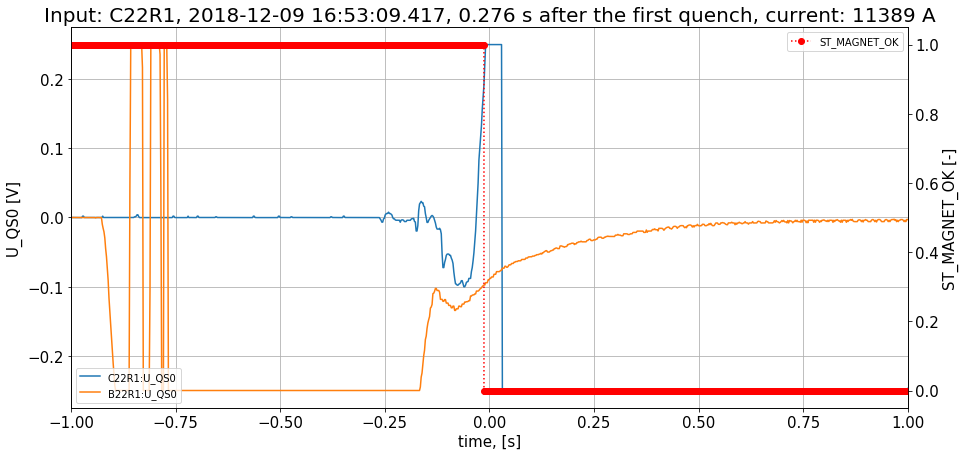

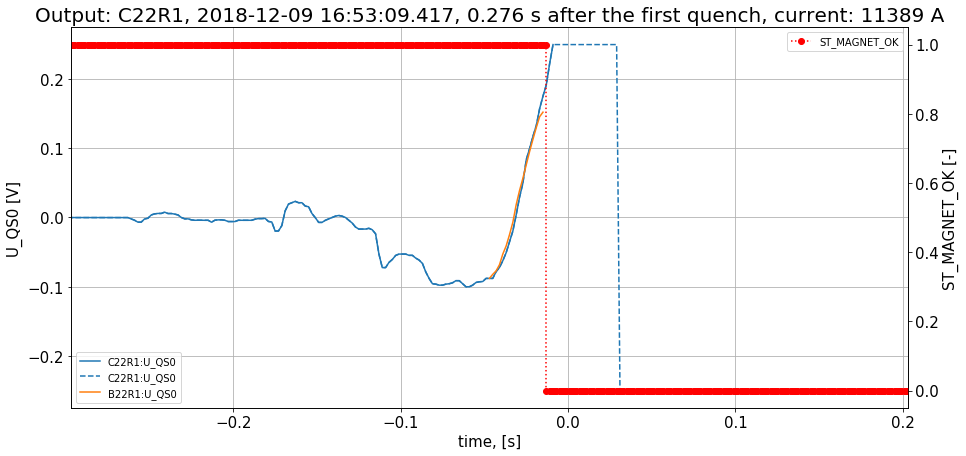

Querying 2018-12-09 16:53:30.630000+01:00 on A22R1:U_QS0.
Querying 2018-12-09 16:53:30.630000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.12307881659895971 at: -0.044 s
The quench of A22R1 is classified as OTHER.


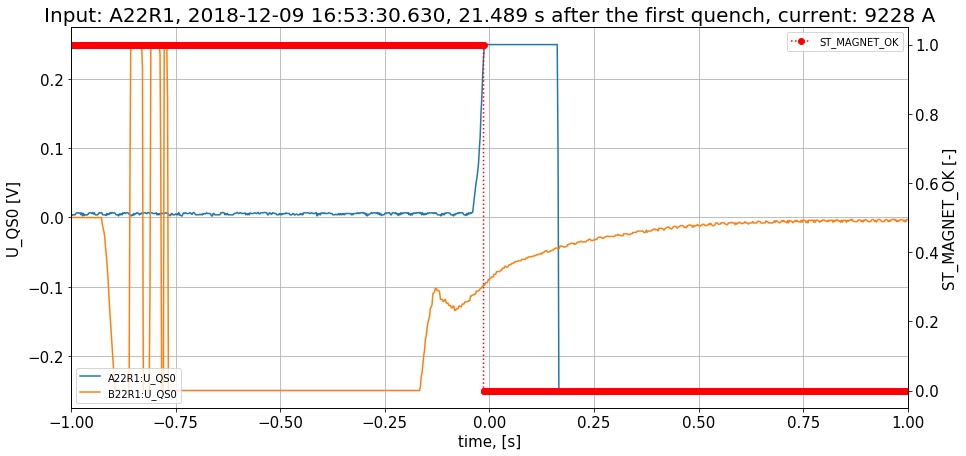

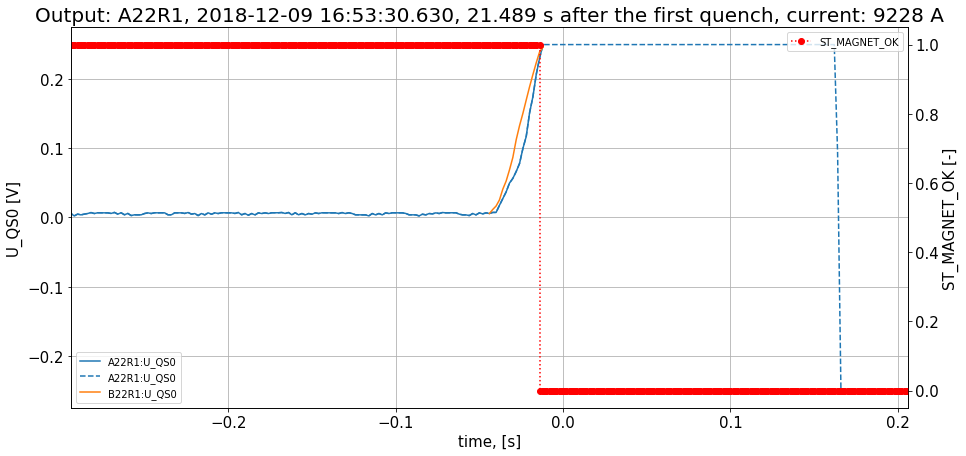

In [7]:
timestamp = '2018-12-09 16:53:00.00'
classify_quench_detection(metadata_qds, metadata_fgc, timestamp, U_QS0_wildcard)

## 2.4. 2018-12-08 16:17:44.00, C16R1, B16R1, A16R1, A17R1, B17R1, C17R1

Querying 2018-12-08 16:17:43.961000+01:00 on C16R1:U_QS0.
Querying 2018-12-08 16:17:43.961000+01:00 on C16R1:U_QS0.
Querying 2018-12-08 16:17:43.961000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.0 at: -0.031 s
The quench of C16R1 is classified as TRAINING.


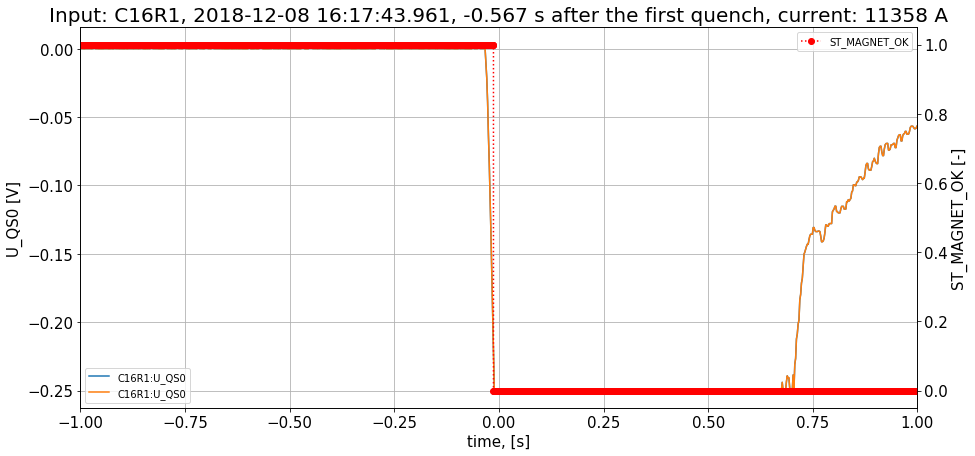

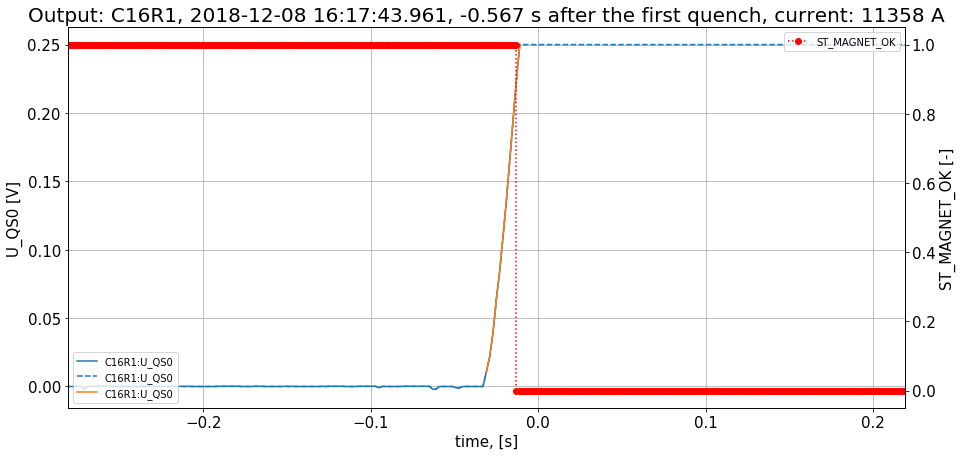

Querying 2018-12-08 16:17:44.182000+01:00 on B16R1:U_QS0.
Querying 2018-12-08 16:17:44.182000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.2103809135730505 at: -1.0 s
The quench of B16R1 is classified as OTHER.


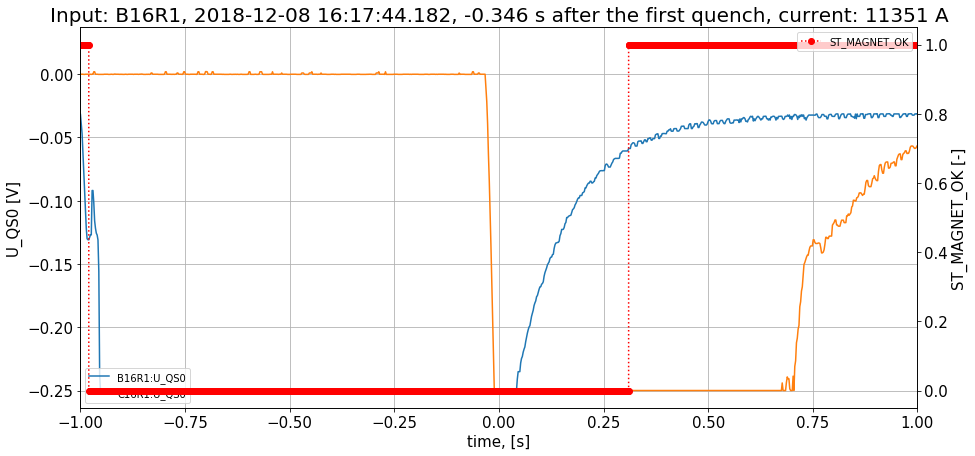

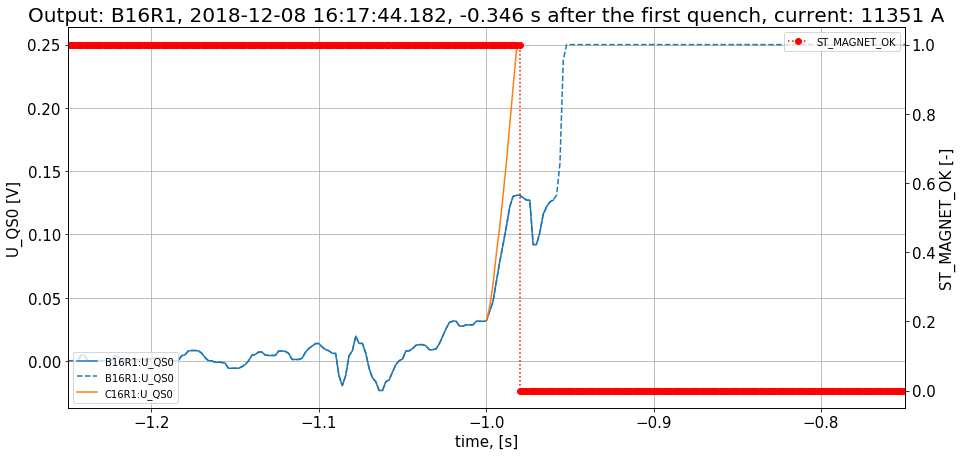

Querying 2018-12-08 16:17:44.478000+01:00 on A16R1:U_QS0.
Querying 2018-12-08 16:17:44.478000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.23496219691511763 at: -0.08 s
The quench of A16R1 is classified as OTHER.


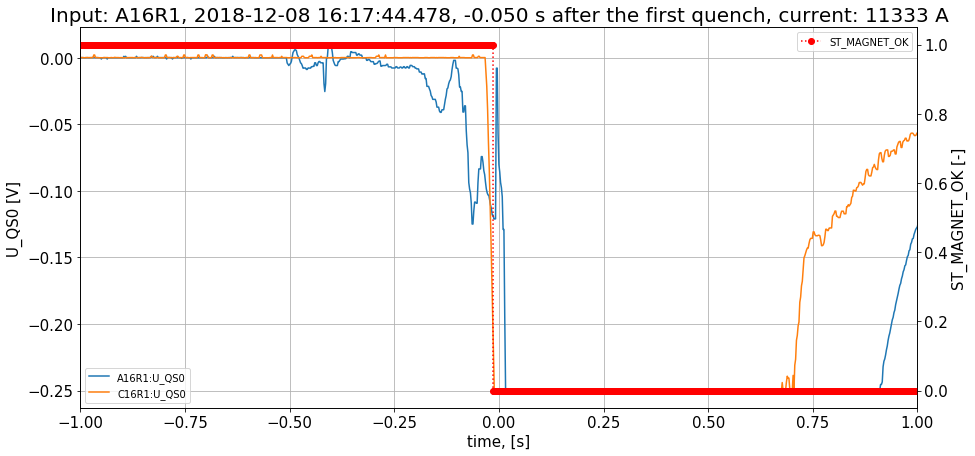

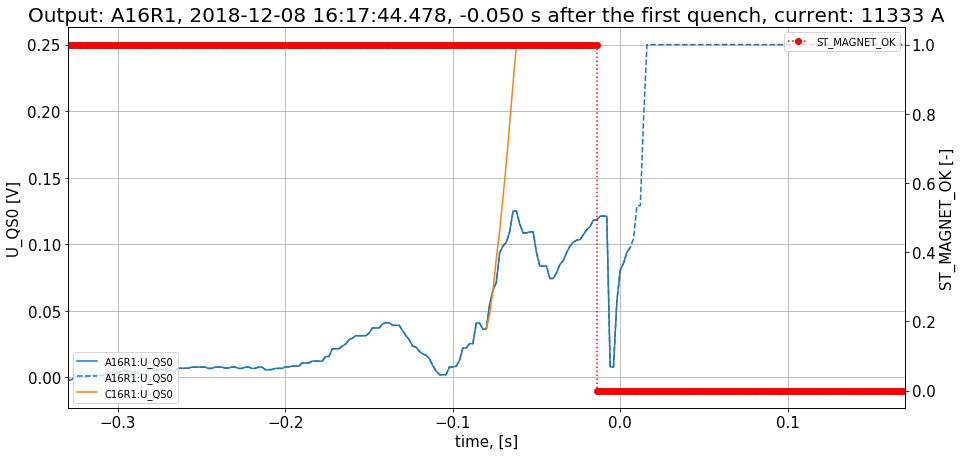

Querying 2018-12-08 16:17:44.528000+01:00 on A17R1:U_QS0.
Querying 2018-12-08 16:17:44.528000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.2989311464600877 at: -0.038 s
The quench of A17R1 is classified as OTHER.


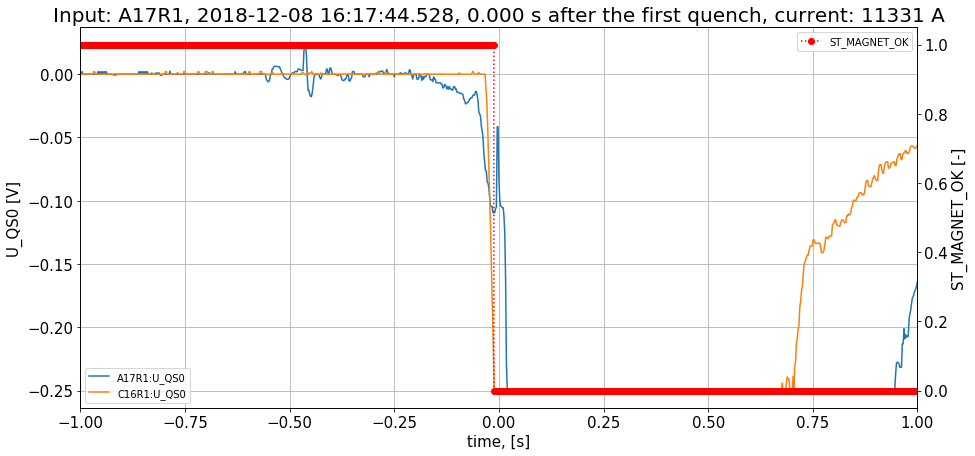

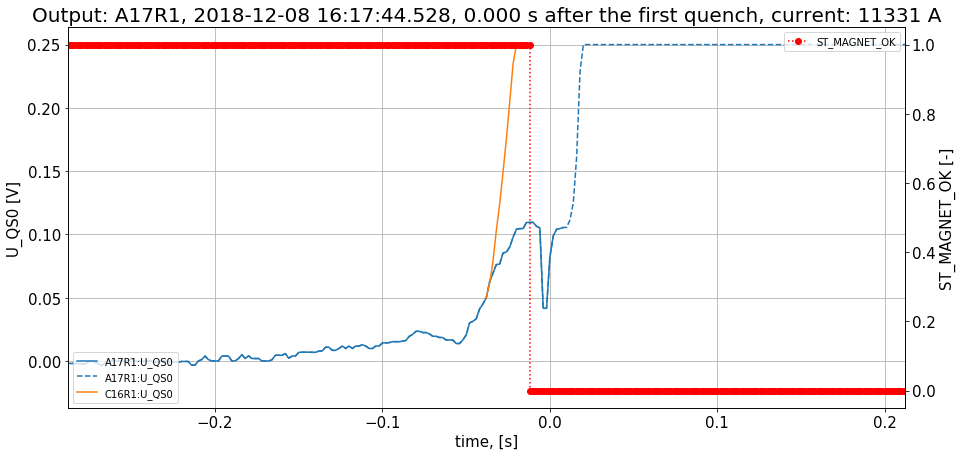

Querying 2018-12-08 16:17:58.540000+01:00 on B17R1:U_QS0.
Querying 2018-12-08 16:17:58.540000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.11936655786545913 at: -0.026 s
The quench of B17R1 is classified as OTHER.


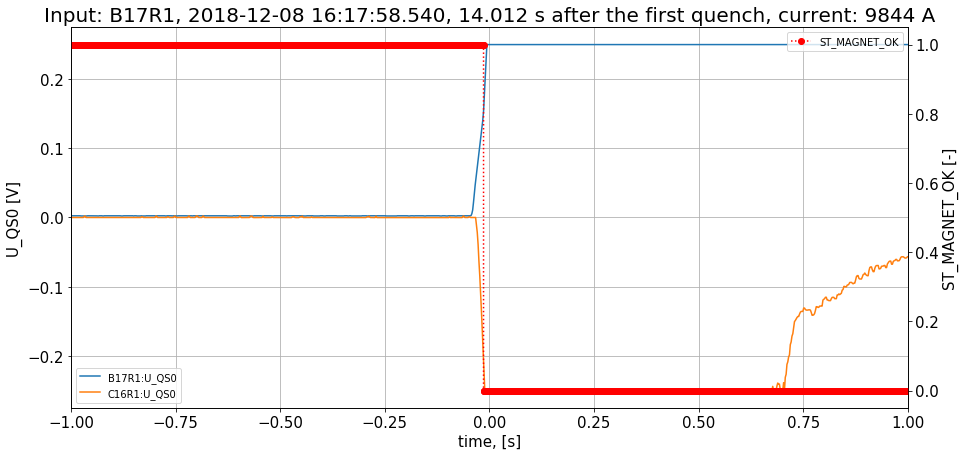

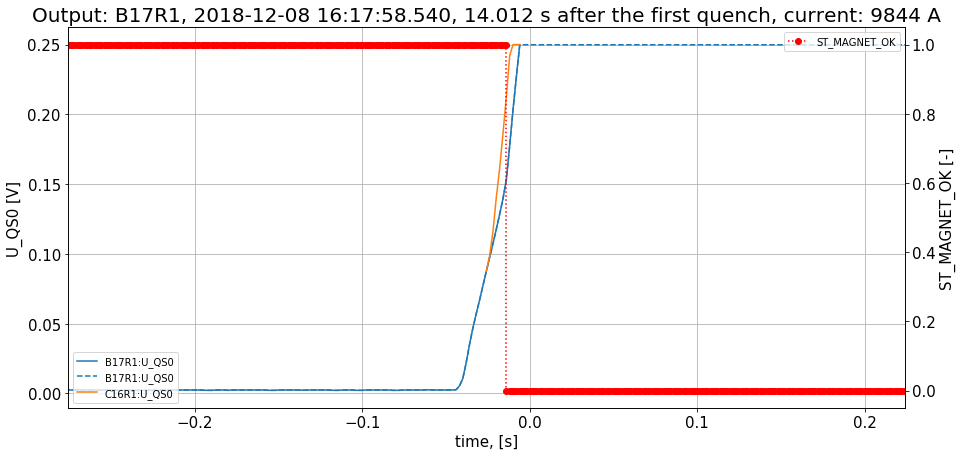

Querying 2018-12-08 16:18:18.273000+01:00 on C17R1:U_QS0.
Querying 2018-12-08 16:18:18.273000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.1552769389801373 at: -0.011 s
The quench of C17R1 is classified as OTHER.


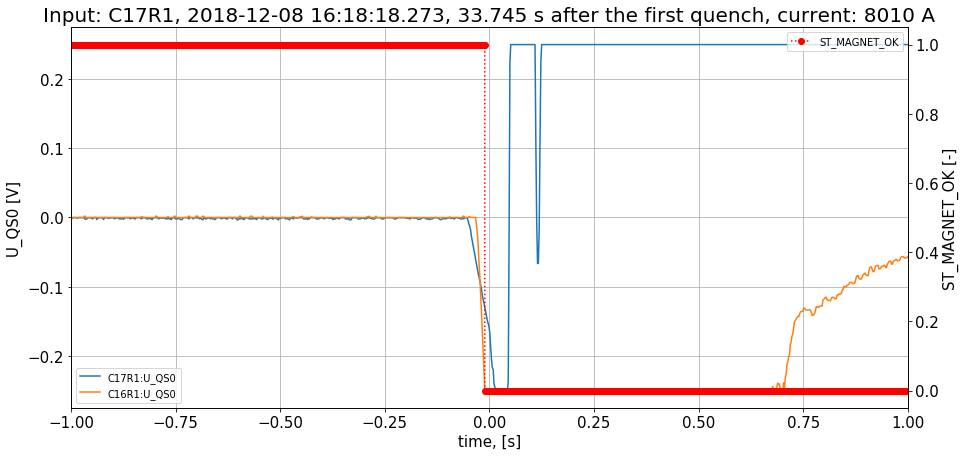

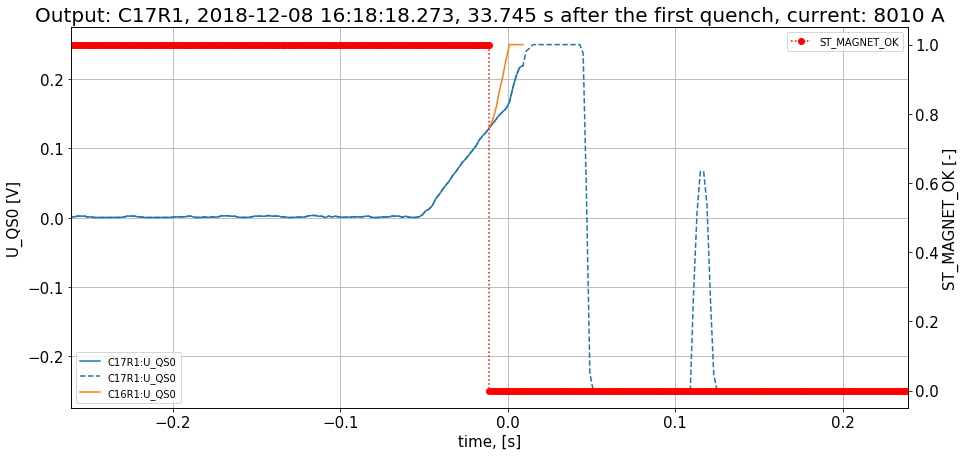

In [8]:
timestamp = '2018-12-08 16:17:44.00'
classify_quench_detection(metadata_qds, metadata_fgc, timestamp, U_QS0_wildcard)

## 2.5. 2018-12-11 21:08:14, A10R1, B10R1, B11R1, A11R1

Querying 2018-12-11 21:08:13.957000+01:00 on A10R1:U_QS0.
Querying 2018-12-11 21:08:13.957000+01:00 on A10R1:U_QS0.
Querying 2018-12-11 21:08:13.957000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.0 at: -0.031 s
The quench of A10R1 is classified as TRAINING.


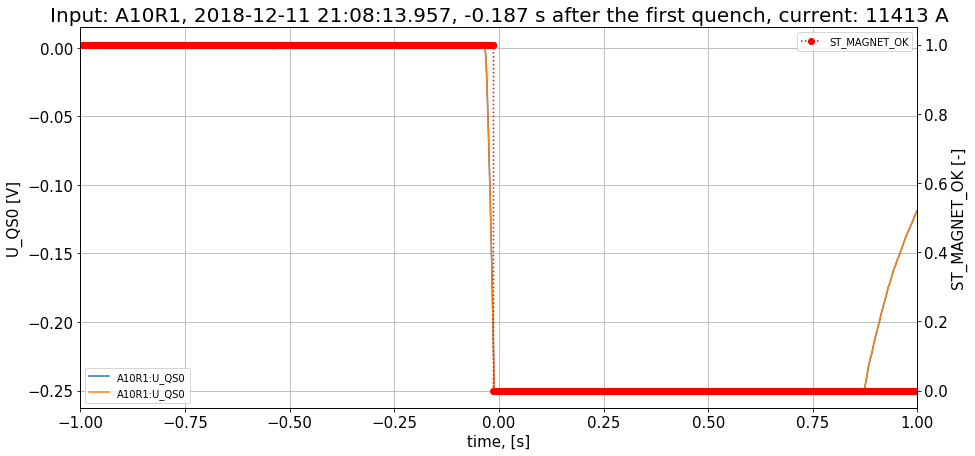

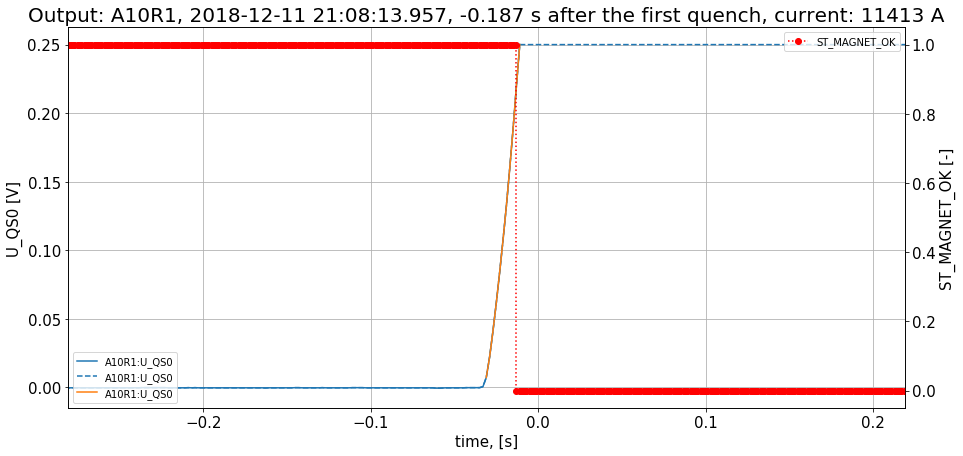

Querying 2018-12-11 21:08:14.144000+01:00 on B10R1:U_QS0.
Querying 2018-12-11 21:08:14.144000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.13066381062740556 at: -0.908 s
The quench of B10R1 is classified as OTHER.


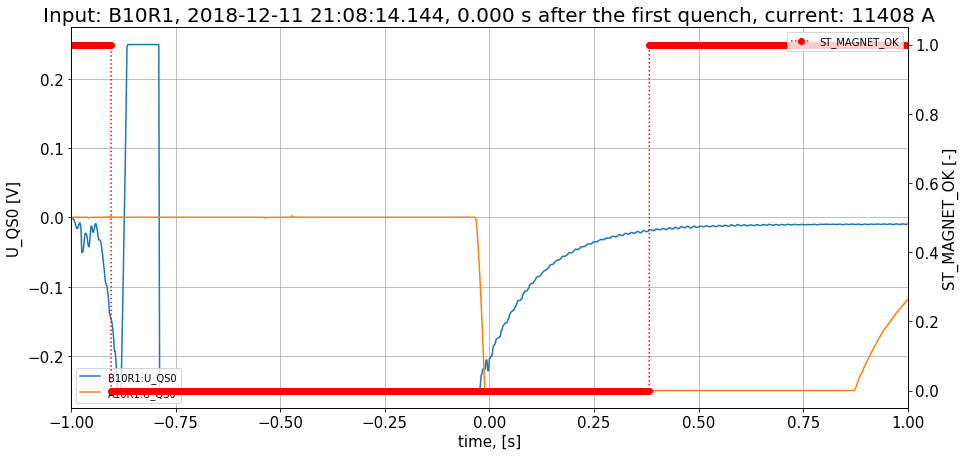

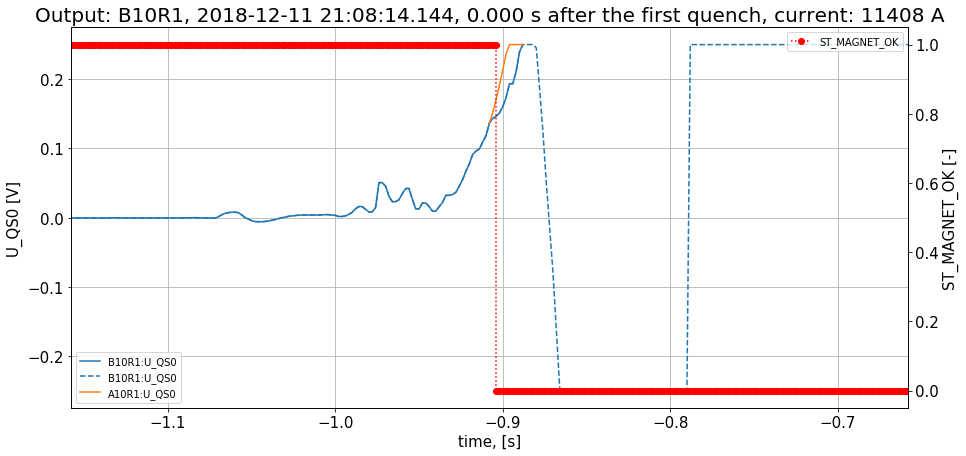

Querying 2018-12-11 21:08:14.375000+01:00 on B11R1:U_QS0.
Querying 2018-12-11 21:08:14.375000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.2741020930809804 at: -0.029 s
The quench of B11R1 is classified as OTHER.


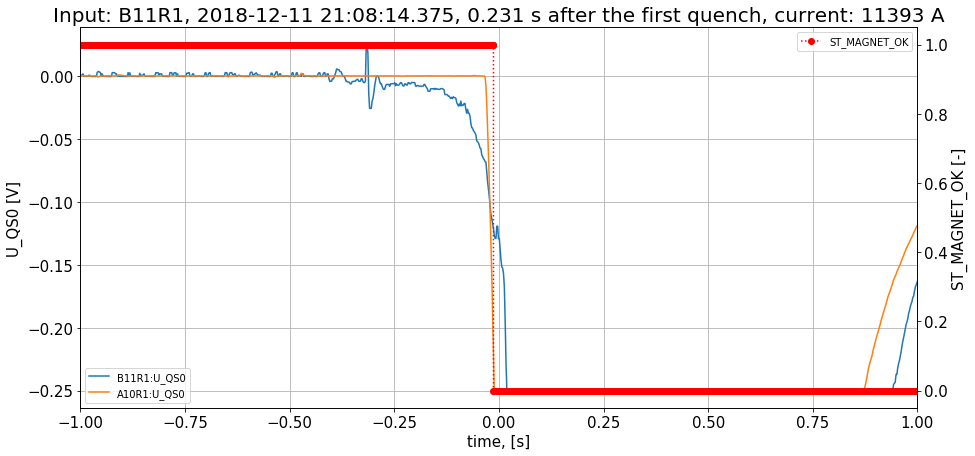

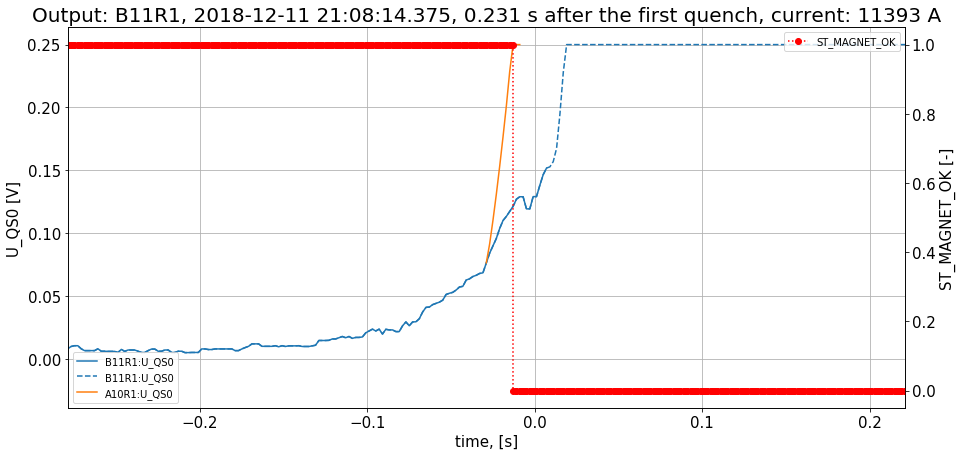

Querying 2018-12-11 21:08:47.454000+01:00 on A11R1:U_QS0.
Querying 2018-12-11 21:08:47.454000+01:00 on ST_MAGNET_OK.
Minimum Euclidean distance to the reference is: 0.19948037718008796 at: -0.012 s
The quench of A11R1 is classified as OTHER.


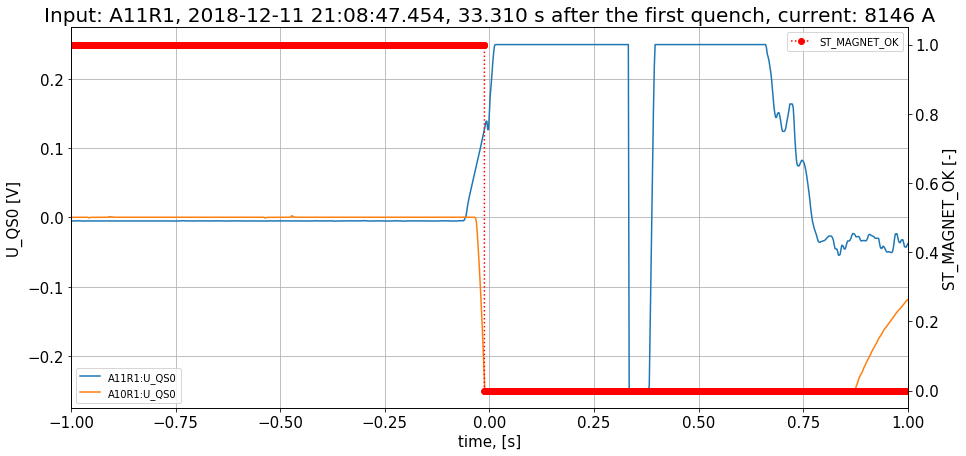

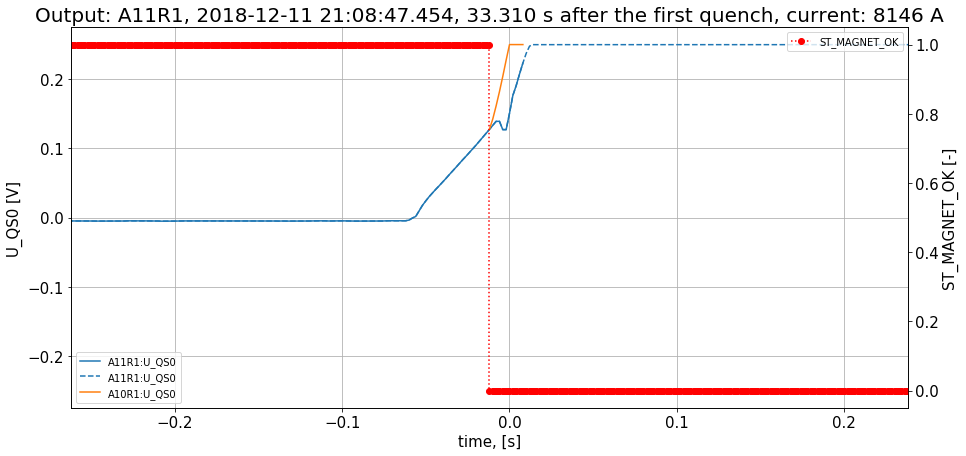

In [9]:
timestamp = '2018-12-11 21:08:14.00'
classify_quench_detection(metadata_qds, metadata_fgc, timestamp, U_QS0_wildcard)

## 3. Toy Example

Maximum correlation is: 1.2277073276281418 at: 0.5


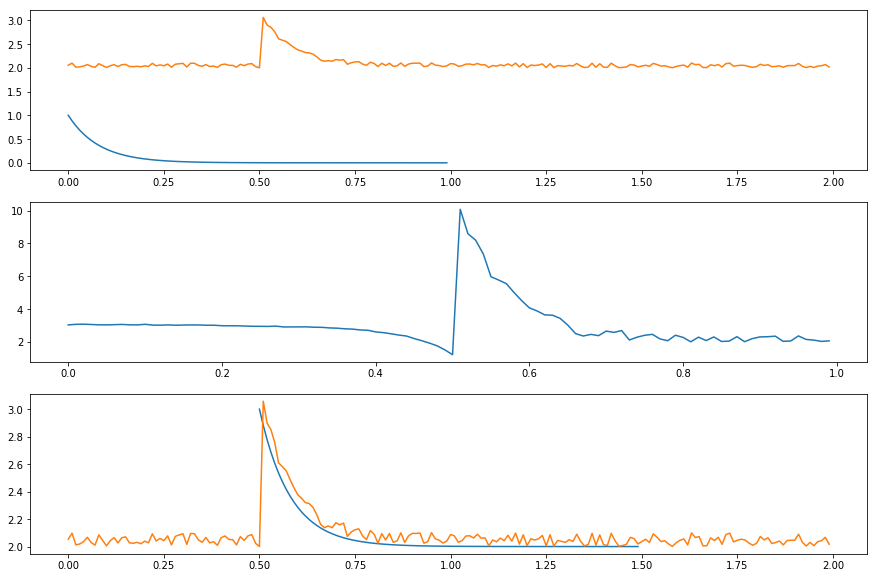

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA

Tinitial= 0.08
Fs = 100;
x_ref = np.arange(0, 1, 1/Fs)
y_ref = np.exp(-x_ref/Tinitial)
x_meas = np.append(np.append(np.arange(0,0.5,1/Fs), x_ref+0.5), np.arange(1.51,2,1/Fs))
y_meas = np.append(np.append(np.zeros(51), y_ref), np.zeros(48))+ 0.1*np.random.rand(len(x_meas))
ref = pd.Series(index=x_ref, data=y_ref)
meas = pd.Series(index=x_meas, data=2+y_meas)

def distance(x, u_qs0_ref_short_values):
    u_qs0_ref_short_values_shifted = deepcopy(u_qs0_ref_short_values)
    u_qs0_ref_short_values_shifted += x[0]
    return LA.norm(x-u_qs0_ref_short_values_shifted)

corrcoeff_pos = meas.rolling(len(ref)).apply(distance, args=(ref.values,), raw=True).shift(-len(ref)+1)

corrcoeff_pos_max, corrcoeff_pos_idx_max = corrcoeff_pos.min(), corrcoeff_pos.idxmin()
print(f"Maximum correlation is: {corrcoeff_pos_max} at: {corrcoeff_pos_idx_max}")

fig, ax = plt.subplots(3, 1, figsize=(15, 10))
# default situation
ref.plot(ax=ax[0])
meas.plot(ax=ax[0])
# cross-corelation result
corrcoeff_pos.plot(ax=ax[1])
# shifted reference signal
ref.index += corrcoeff_pos_idx_max
ref = ref.add(meas.loc[corrcoeff_pos_idx_max])
ref.plot(ax=ax[2])
meas.plot(ax=ax[2])